In [74]:
import os
import random
import numpy as np
import pandas as pd  # Added import
import json
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt

In [76]:
# Set the main dataset directory and other parameters
dataset_dir = 'DataSet'
input_shape = (150, 150, 3)
num_classes = len(os.listdir(dataset_dir))
batch_size = 32
epochs = 100
test_size = 0.2

In [77]:
# Get the list of all image files
# image_files = []
# labels = []
# for label in os.listdir(dataset_dir):
#     label_dir = os.path.join(dataset_dir, label)
#     if os.path.isdir(label_dir):
#         for file_name in os.listdir(label_dir):
#             image_files.append(os.path.join(label_dir, file_name))
#             labels.append(label)
# # Get the list of all image files
# image_files = []
# labels = []
# for label in os.listdir(dataset_dir):
#     label_dir = os.path.join(dataset_dir, label)
#     if os.path.isdir(label_dir):
#         for file_name in os.listdir(label_dir):
#             image_path = os.path.join(label_dir, file_name)
#             image_files.append(image_path)
#             labels.append(label)

#             # Check image metadata for orientation information
#             with Image.open(image_path) as img:
#                 metadata = img._getexif()
#                 if metadata is not None and 0x0112 in metadata:
#                     orientation = metadata[0x0112]
#                     print(f"Orientation of {image_path}: {orientation}")
# Perform train-test split
# train_files, validation_files, train_labels, validation_labels = train_test_split(
#     image_files, labels, test_size=test_size, stratify=labels, random_state=42
# )
# Preprocess images to correct rotation (portrait orientation)
# for file_path in train_files + validation_files:
#     img = Image.open(file_path)
#     width, height = img.size
#     if width > height:  # Landscape orientation
#         img = img.transpose(Image.ROTATE_90)
#         img.save(file_path)

# Get the list of all image files
# Get the list of all image files and their corresponding labels
image_files = []
labels = []

for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        for file_name in os.listdir(label_dir):
            image_files.append(os.path.join(label_dir, file_name))
            labels.append(label)

# Perform train-test split
train_files, validation_files, train_labels, validation_labels = train_test_split(
    image_files, labels, test_size=test_size, stratify=labels, random_state=42
)

Found 3541 validated image filenames belonging to 26 classes.
Found 886 validated image filenames belonging to 26 classes.


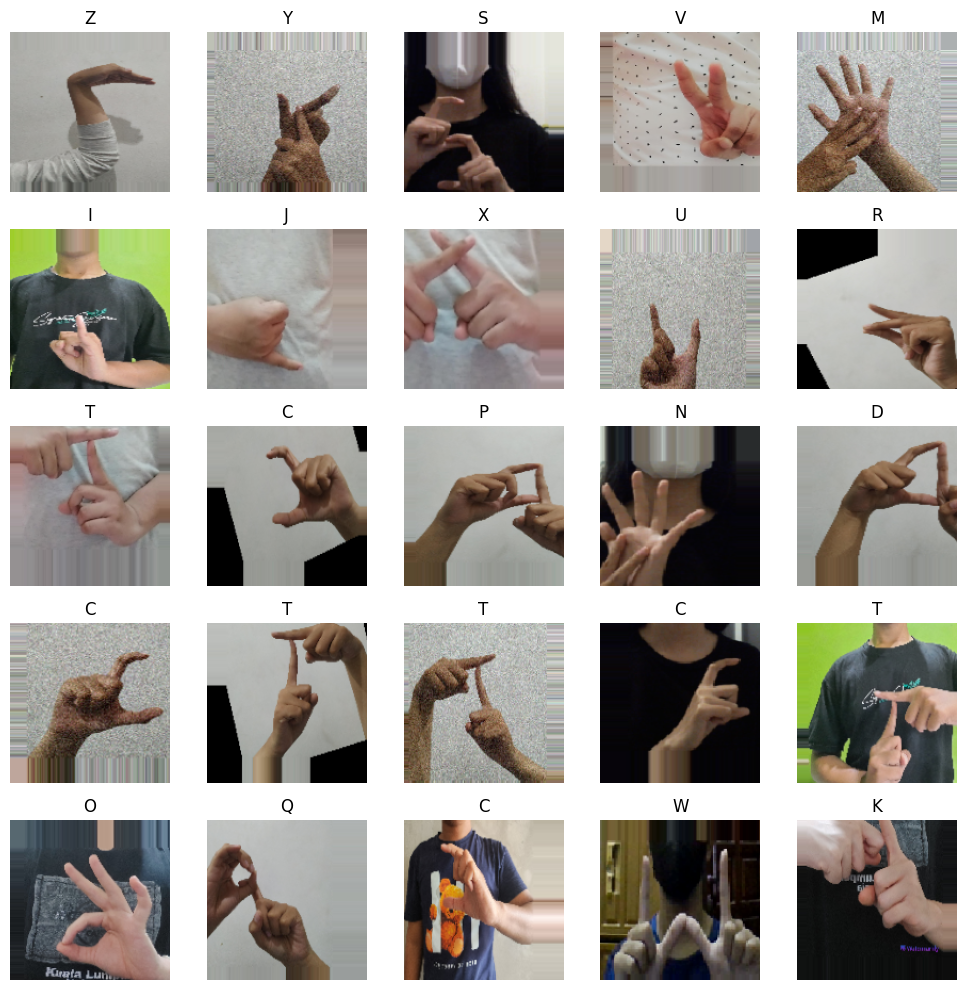

In [78]:
# Create image data generator with augmentation
datagen = ImageDataGenerator(   rescale=1/255,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest'
                                
)
# Convert labels to string type
train_labels = [str(label) for label in train_labels]
validation_labels = [str(label) for label in validation_labels]
# Generate training and validation data
train_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'label': train_labels}),
    x_col='filename',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': validation_files, 'label': validation_labels}),
    x_col='filename',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)
# Display sample data
# sample_images, sample_labels = next(train_generator)

# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i+1)
#     plt.imshow(sample_images[i])
#     plt.title(sample_labels[i])
#     plt.axis('off')

# plt.tight_layout()
# plt.show()


# Sort the class labels alphabetically
sorted_labels = sorted(train_generator.class_indices.keys())

# Display sample data
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(sorted_labels[np.argmax(sample_labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()



In [79]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 17, 17, 64)      

In [80]:
# Define callback to stop training if accuracy exceeds 90%
class AccuracyThresholdCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.83 :
            print("\nReached 90% validation accuracy. Stopping training.")
            self.model.stop_training = True

In [81]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[AccuracyThresholdCallback()]
)



Epoch 1/100
110/110 [==============================] - 183s 2s/step - loss: 3.1937 - accuracy: 0.0727 - val_loss: 2.9737 - val_accuracy: 0.1539
Epoch 2/100
110/110 [==============================] - 183s 2s/step - loss: 2.9150 - accuracy: 0.1547 - val_loss: 2.6668 - val_accuracy: 0.2442
Epoch 3/100
110/110 [==============================] - 182s 2s/step - loss: 2.5306 - accuracy: 0.2374 - val_loss: 2.2442 - val_accuracy: 0.3611
Epoch 4/100
110/110 [==============================] - 181s 2s/step - loss: 2.2427 - accuracy: 0.3015 - val_loss: 1.9463 - val_accuracy: 0.4514
Epoch 5/100
110/110 [==============================] - 181s 2s/step - loss: 2.0755 - accuracy: 0.3665 - val_loss: 1.7870 - val_accuracy: 0.4850
Epoch 6/100
110/110 [==============================] - 181s 2s/step - loss: 1.8522 - accuracy: 0.4203 - val_loss: 1.5830 - val_accuracy: 0.5648
Epoch 7/100
110/110 [==============================] - 173s 2s/step - loss: 1.6610 - accuracy: 0.4762 - val_loss: 1.4470 - val_accuracy:

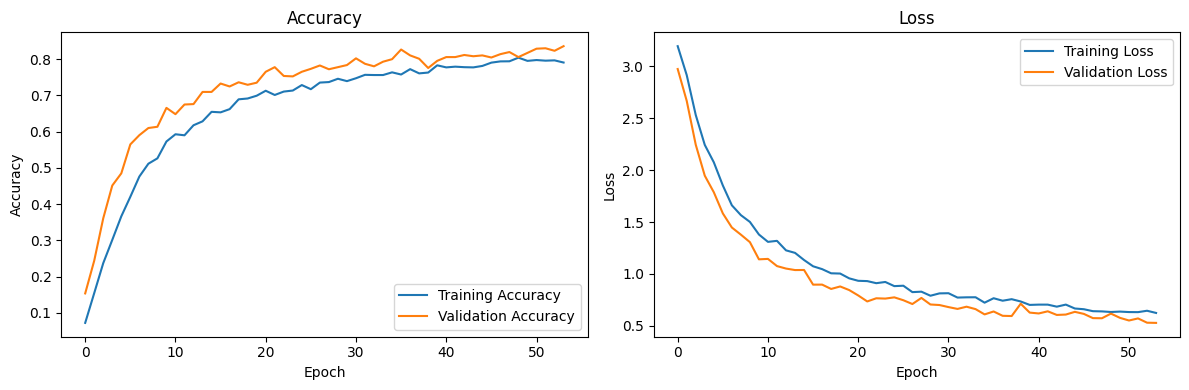

In [82]:
# Plot accuracy and loss curves
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
# Print out loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss[epoch]:.4f} - Train Accuracy: {train_accuracy[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f} - Validation Accuracy: {val_accuracy[epoch]:.4f}")
    print()

Epoch 1/100
Train Loss: 3.1937 - Train Accuracy: 0.0727
Validation Loss: 2.9737 - Validation Accuracy: 0.1539

Epoch 2/100
Train Loss: 2.9150 - Train Accuracy: 0.1547
Validation Loss: 2.6668 - Validation Accuracy: 0.2442

Epoch 3/100
Train Loss: 2.5306 - Train Accuracy: 0.2374
Validation Loss: 2.2442 - Validation Accuracy: 0.3611

Epoch 4/100
Train Loss: 2.2427 - Train Accuracy: 0.3015
Validation Loss: 1.9463 - Validation Accuracy: 0.4514

Epoch 5/100
Train Loss: 2.0755 - Train Accuracy: 0.3665
Validation Loss: 1.7870 - Validation Accuracy: 0.4850

Epoch 6/100
Train Loss: 1.8522 - Train Accuracy: 0.4203
Validation Loss: 1.5830 - Validation Accuracy: 0.5648

Epoch 7/100
Train Loss: 1.6610 - Train Accuracy: 0.4762
Validation Loss: 1.4470 - Validation Accuracy: 0.5903

Epoch 8/100
Train Loss: 1.5662 - Train Accuracy: 0.5115
Validation Loss: 1.3782 - Validation Accuracy: 0.6100

Epoch 9/100
Train Loss: 1.5008 - Train Accuracy: 0.5264
Validation Loss: 1.3060 - Validation Accuracy: 0.6134

E

IndexError: list index out of range

In [85]:
# Save the trained model
model.save('image_classifier_model_6.h5')

In [86]:
from tensorflow.keras.models import model_from_json
# Load the model from .h5 file
model = keras.models.load_model('image_classifier_model_6.h5')

# Convert model architecture to JSON
model_json = model.to_json()

# Save the JSON to a file
with open('image_classifier_model_6.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights to a separate file
model.save_weights('image_classifier_weights_6.h5')

print("Model converted to JSON and saved as image_classifier_model.json.")

Model converted to JSON and saved as image_classifier_model.json.
